using rdflib version; 5.0.0-dev, at: ['/Users/jjc/ComputerInfo/RDF/rdflib/rdflib']


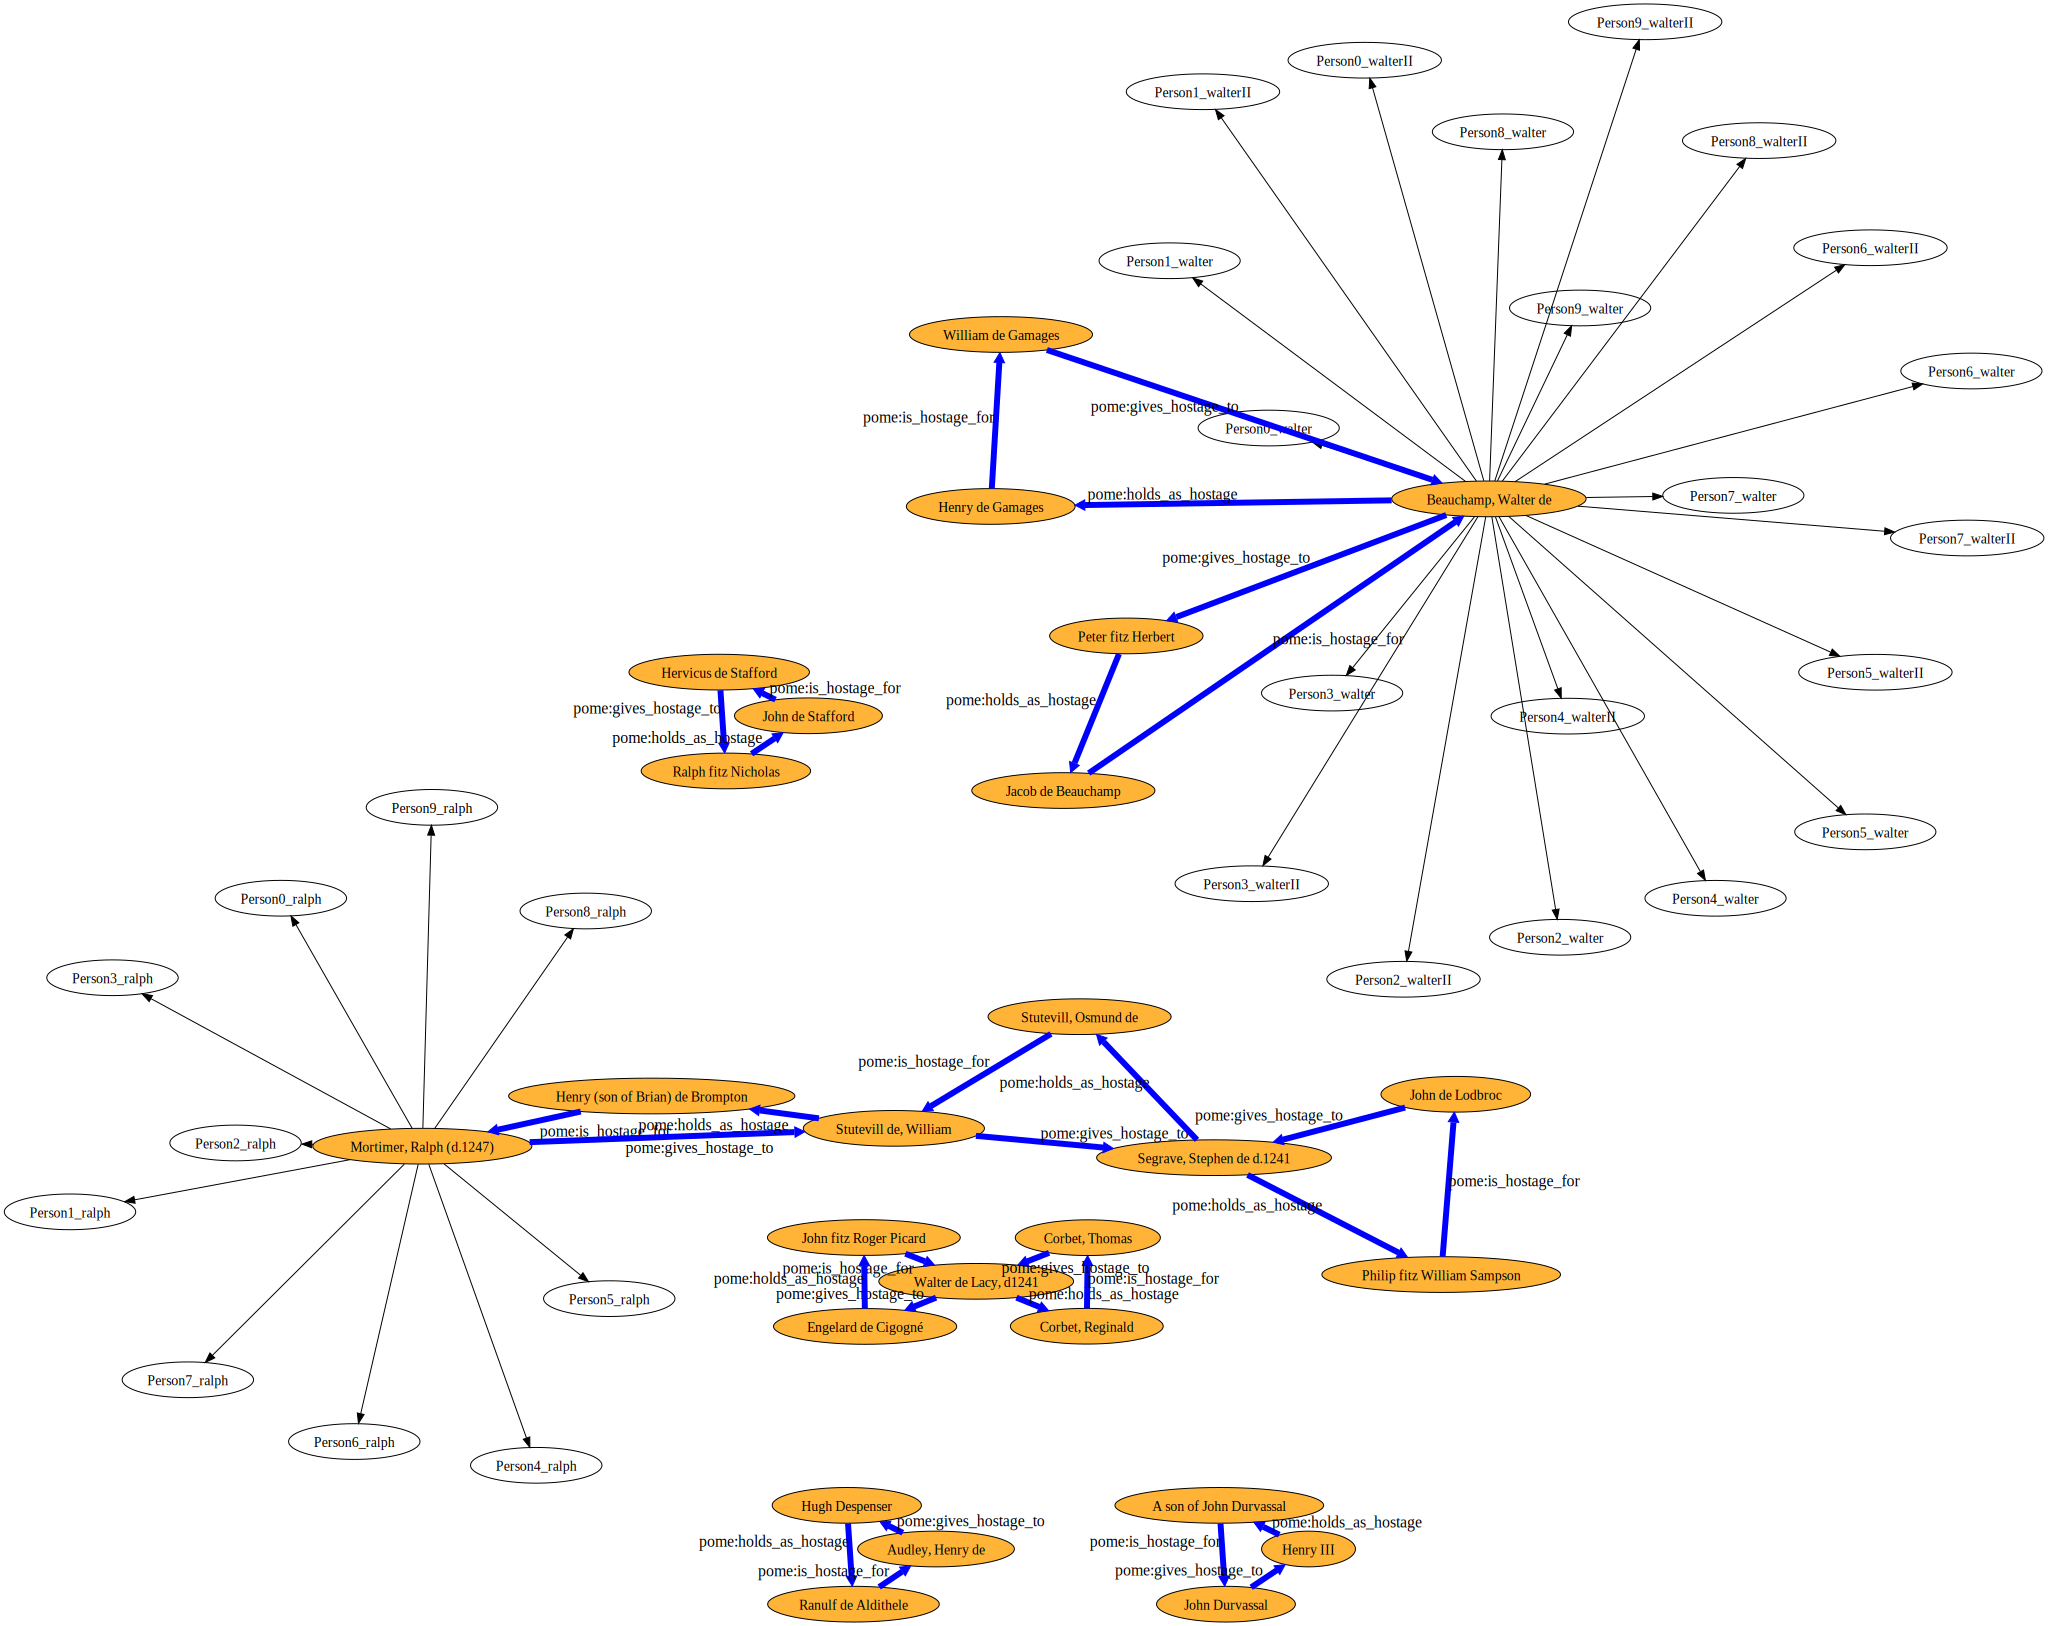

In [30]:
# !/opt/local/bin/python
# -*- coding: utf-8 -*- # 
# noodling on Popper
import sys
sys.path.insert(0, "/Users/jjc/ComputerInfo/RDF/rdflib/")
from hashlib import sha1
import rdflib
from rdflib import ConjunctiveGraph, Graph, Namespace, RDF
from rdflib.term import URIRef, Literal, BNode
from rdflib.extras import external_graph_libs as egl
from pprint import pprint
import yaml
import pydot
import pygraphviz as pgv
import networkx as nx
print "using rdflib version; %s, at: %s" % (rdflib.__version__, rdflib.__path__)

cg = ConjunctiveGraph(identifier="basegraph")
cg.load("/Users/jjc/Documents/Dissertation/Notes/1233HostageDeal/modelTesting/hostages9_15.trig", format='trig')

cg.namespace_manager.bind('oa', URIRef('http://www.w3.org/ns/oa#'))
cg.namespace_manager.bind('xml', URIRef('http://www.w3.org/XML/1998/namespace'))
cg.namespace_manager.bind('foaf', URIRef('http://xmlns.com/foaf/0.1/'))
cg.namespace_manager.bind('snotes', URIRef('http://my.sourcenotes.org/2006/04/sourcenotes#'))
cg.namespace_manager.bind('heml', URIRef('http://www.heml.org/schemas/2003-09-17/heml#'))
cg.namespace_manager.bind('owl', URIRef('http://www.w3.org/2002/07/owl#'))
cg.namespace_manager.bind('rdf', URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#'))
cg.namespace_manager.bind('rdfs', URIRef('http://www.w3.org/2000/01/rdf-schema#'))
cg.namespace_manager.bind('dc', URIRef('http://purl.org/dc/elements/1.1/'))
cg.namespace_manager.bind('dct', URIRef('http://purl.org/dc/terms/'))
cg.namespace_manager.bind('rel', URIRef('http://purl.org/vocab/relationship#'))
cg.namespace_manager.bind('pome', URIRef('http://prosopOnto.medieval.england/2006/04/pome#'))
cg.namespace_manager.bind('crm', URIRef('http://cidoc.ics.forth.gr/rdfs/cidoc_v4.2.rdfs#'))
cg.namespace_manager.bind('h10', URIRef('http://example.com/thisgraph#'))

xml = Namespace('http://www.w3.org/XML/1998/namespace')
owl = Namespace('http://www.w3.org/2002/07/owl#')
foaf = Namespace('http://xmlns.com/foaf/0.1/')
oa = Namespace('http://www.w3.org/ns/oa#')
snotes = Namespace('http://my.sourcenotes.org/2006/04/sourcenotes#')
heml = Namespace('http://www.heml.org/schemas/2003-09-17/heml#')
rdf = Namespace('http://www.w3.org/1999/02/22-rdf-syntax-ns#')
rdfs = Namespace('http://www.w3.org/2000/01/rdf-schema#')
dc = Namespace('http://purl.org/dc/elements/1.1/')
dct = Namespace('http://purl.org/dc/terms/')
pome = Namespace('http://prosopOnto.medieval.england/2006/04/pome#')
rel = Namespace('http://purl.org/vocab/relationship#')
crm = Namespace('http://cidoc.ics.forth.gr/rdfs/cidoc_v4.2.rdfs#')
h10 = Namespace('http://example.com/thisgraph#')

predicate_filter = [#crm.participated_in
    rel.spouseOf,
    rel.childOf]
hostage_predicates = [
    pome.gives_hostage_to, 
    pome.holds_as_hostage, 
    pome.is_hostage_for
    ]


def hostages2dot(rdf, filter):
    if len(rdf) == 0:
        return "sorry, nothing there. The graph has no nodes"
    
    dg = pgv.AGraph(strict=True, directed=True, fontname="Times-Roman")

    for s,p,o in rdf.triples((None,None,None)):
        if p in filter:
            dg.add_node(
                s,
                label = rdf.value(s, rdfs.label),
                style = 'filled',
                fillcolor = "#dddddd",
                shape = 'ellipse',
                id = str(s),
                tooltip = str(s)
            )
            
            dg.add_node(
                o,
                label = rdf.value(o, rdfs.label),
                style = 'filled',
                fillcolor = "#dddddd",
                shape = 'ellipse',
                id = str(o),
                tooltip = str(o)
            )

            dg.add_edge(
                s, o,
                label = rdf.qname(p),
                fontsize=9,
                tooltip = str(s) + ', ' + rdf.qname(p) + ', ' + str(o)                    
            )

    maxDegreeNode = max([x for x in dg.iterdegree()], key= lambda tup: tup[1])
    dg.graph_attr.update(root = maxDegreeNode[0], model="circuit", overlap=False, len=1)
    
    # let's see a bunch of some random nodes:
    ralph = "http://example.com/thisgraph#Mortimer_Ralph_d_1247"
    walter = "http://example.com/thisgraph#Beauchamp_Walter_de"
    for x in range(10):
        
        dg.add_edge(
            ralph, "Person%d_ralph" % x
        )
        dg.add_edge(
            walter, "Person%d_walter" % x
        )
        dg.add_edge(
            walter, "Person%d_walterII" % x
        )
    
    return dg

pgraph = hostages2dot(cg, hostage_predicates)

####################### NETWORKX to get simple cycles #######################
# Finding cycles turns out to be more difficult than I thought. The NetworkX
# algorithm makes use of Johnson's algorithm,  which in turn entails Bellman–Ford
# algorithm and Dijkstra's algorithm.

# Get NX graph from rdf:
nxmdg = egl.rdflib_to_networkx_multidigraph(cg)

# Get hostage edges as NX ebunch
hedges = [e for e in nxmdg.edges_iter(data=True, keys=True) if e[2] in hostage_predicates]
    ######## that is, a list of tuples like this:
    # (rdflib.term.URIRef(u'http://example.com/thisgraph#Henry_III'), rdflib.term.URIRef(u'http://example.com/thisgraph#A_son_of_John_Durvassal'), rdflib.term.URIRef(u'http://prosopOnto.medieval.england/2006/04/pome#holds_as_hostage'), {})

    
    
# make nx graph with subset: just hostage edges, and get cycles
# bear in mind that simple_cycles will return ALL such cycles, so we need
# to be sure we're operating on a FILTERED graph: only hedges.
mdg = nx.MultiDiGraph()
mdg.add_edges_from(hedges)
cycles = nx.simple_cycles(mdg)

# add cycles as subgraphs (adds no edges)
for c in cycles:
    for n in c:
        pgraph.add_node(n, label=cg.value(n, rdfs.label)) #NB: adds only nodes not present
        pgraph.get_node(n).attr.update(style = 'filled', fillcolor = "#ffb438")

    pgraph.add_subgraph(c, name="cluster_cycle%d" % cycles.index(c))

# The edges were written to mdg in order to find the cycles, but not yet added
# to pgraph, that's why they have to be added below
# add hostage edges
for e in hedges:
    s,o,p,d = e
    
    pgraph.add_edge(s,o,
        constraint=True,
        len=10.0,
        label=cg.qname(p),
        penwidth=6,
        color='blue',
        fontsize=16
    )

sgraphs_attrs = {"style": "filled", "color":"#ccffee"}
for g in pgraph.subgraphs_iter():
    pgraph.get_subgraph(g.get_name()).graph_attr.update(sgraphs_attrs)
        
######### sfdp is nice, but it doesn't render the subgraph clusters, for that, use neato
hostagesvg = open('/Users/jjc/Desktop/hostage.svg', 'w')
hostagesvg.write(pgraph.draw(format='svg', prog='sfdp'))
hostagesvg.close()

######################


from lxml import etree as et

tree = et.parse('/Users/jjc/Desktop/hostage.svg')
root = tree.getroot()
# print(dir(root))
# print(root.items())
root.set('width','100%')
root.set('height','100%')

tree.write('/Users/jjc/Desktop/hostage.svg')

from IPython.display import SVG

SVG(filename='/Users/jjc/Desktop/hostage.svg')

In [185]:
from IPython.display import Javascript
print help(Javascript)

Help on class Javascript in module IPython.core.display:

class Javascript(TextDisplayObject)
 |  Method resolution order:
 |      Javascript
 |      TextDisplayObject
 |      DisplayObject
 |      __builtin__.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, data=None, url=None, filename=None, lib=None, css=None)
 |      Create a Javascript display object given raw data.
 |      
 |      When this object is returned by an expression or passed to the
 |      display function, it will result in the data being displayed
 |      in the frontend. If the data is a URL, the data will first be
 |      downloaded and then displayed.
 |      
 |      In the Notebook, the containing element will be available as `element`,
 |      and jQuery will be available.  Content appended to `element` will be
 |      visible in the output area. 
 |      
 |      Parameters
 |      ----------
 |      data : unicode, str or bytes
 |          The Javascript source code or a URL to download it from.